# Installing necessary Libraries

In [2]:
! pip install pypdf2
! pip install wikipedia
! pip install openai
! pip install chromadb langchain sentence-transformers
! pip install ragas transformers datasets matplotlib seaborn torch peft trl
! pip install langchain-openai
! pip install rapidfuzz
! pip install bitsandbytes gradio
! pip install colbert-ai
! pip install duckduckgo-search
!pip install rouge-score
!pip install kiln-ai

!pip install unsloth
!git clone https://github.com/ggerganov/llama.cpp.git
!cd llama.cpp && make

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=c61aa517f6f13c5fed5f0183aee50d89ce97dc4d16751d91605ee361fb2ed6c6
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 15.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 57.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Dataset Preparation

In [3]:
import os
import PyPDF2
from glob import glob
import wikipedia
from langchain.text_splitter import CharacterTextSplitter
import re
import nltk
from nltk.corpus import stopwords

### 1. Given Data

In [4]:
dir_path = "/kaggle/input/datasettask3"
files = os.listdir(dir_path)

print("Files in the folder:", files)

Files in the folder: ['dataset.md', 'design-notes-3fs.md', 'deepseekv3-cost-explained.md', '2501.12948v1.pdf', 'deepseekv3-explained.md', 'open-source-week.md']


In [5]:
files = glob(os.path.join(dir_path, "*.md")) + glob(os.path.join(dir_path, "*.pdf"))
documents = []

for file in files:
    if file.endswith(".md"):
        with open(file, "r", encoding="utf-8") as f:
            documents.append(f.read())
    elif file.endswith(".pdf"):
        with open(file, "rb") as f:
            pdf_reader = PyPDF2.PdfReader(f)
            text = "".join(page.extract_text() or "" for page in pdf_reader.pages)
            documents.append(text)

print(f"Loaded {len(documents)} documents: {[os.path.basename(f) for f in files]}")

Loaded 6 documents: ['dataset.md', 'design-notes-3fs.md', 'deepseekv3-cost-explained.md', 'deepseekv3-explained.md', 'open-source-week.md', '2501.12948v1.pdf']


### 2. Custom data

In [6]:
wikipedia.set_lang("en")

pages = [
    "Artificial Intelligence",
    "Natural Language Processing",
    "DeepSeek",
    "Deep Learning",
    "AI Research" 
]

wiki_data = []
for page in pages:
    try:
        content = wikipedia.page(page).content
        wiki_data.append(content)
    except Exception as e:
        print(f"Error fetching {page}: {e}")

with open("wiki_ai_data.txt", "w", encoding="utf-8") as f:
    f.write("\n\n".join(wiki_data))

# Preprocessing

In [7]:
wiki_cleaned = [" ".join(doc.split()) for doc in wiki_data]
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
wiki_chunks = [chunk for doc in wiki_cleaned for chunk in text_splitter.split_text(doc)]

documents.extend(wiki_cleaned)  

In [8]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text.strip())  # Normalize whitespace
    text = re.sub(r'[^\w\s.,!?]', '', text)   # Remove special characters except basic punctuation
    return text

documents = [clean_text(doc) for doc in documents]

In [9]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

documents = [" ".join([word for word in doc.split() if word not in stop_words]) for doc in documents]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
documents = [" ".join(doc.split()) for doc in documents]
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
all_chunks = [chunk for doc in documents for chunk in text_splitter.split_text(doc)]

# Synthetic Data Generation (Q n A)

In [11]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator
from langchain.docstore.document import Document

In [12]:
os.environ["OPENAI_API_KEY"] = "add-your-api-key"

In [13]:
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [14]:
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)

In [16]:
langchain_docs = [Document(page_content=chunk) for chunk in all_chunks]
dataset = generator.generate(documents, 10, num_personas=0)


In [17]:
pandas_df = dataset.to_pandas()
synthetic_dataset = Dataset.from_pandas(pandas_df)

# Rename columns to match desired format
column_mapping = {
    "user_input": "question",
    "reference": "answer",
    "reference_contexts": "contexts"
}
synthetic_dataset = synthetic_dataset.rename_columns(column_mapping)


In [18]:
# Map synthesizer_name to question_type (simplified)
def map_question_type(synth_name):
    if "single_hop" in synth_name:
        return "simple"
    elif "multi_hop" in synth_name:
        return "reasoning"
    else:
        return "multi_context"

synthetic_dataset = synthetic_dataset.map(
    lambda x: {"question_type": map_question_type(x["synthesizer_name"])}
)
synthetic_dataset = synthetic_dataset.remove_columns(["synthesizer_name"])  # Drop old column


In [19]:
# Split into train/test
train_test = synthetic_dataset.train_test_split(test_size=0.2)
train_dataset = train_test["train"]
test_dataset = train_test["test"]

# Save
train_dataset.save_to_disk("./synthetic_train")
test_dataset.save_to_disk("./synthetic_test")

In [20]:
os.environ["RAGAS_APP_TOKEN"] = "add-your-ragas-app-token"
dataset.upload()

Can access the ragas dashboard at localhost:3000

# PEFT on Qwen 2.5-Instruct 

In [21]:
from datasets import load_from_disk
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from transformers import Trainer
from transformers import TrainingArguments
from trl import SFTTrainer

In [23]:
train_dataset = load_from_disk("./synthetic_train")
test_dataset = load_from_disk("./synthetic_test")

# Format for instruction tuning
def format_prompt(example):
    return {"text": f"### Question: {example['question']}\n### Answer: {example['answer']} <|seperator|> "}

train_dataset = train_dataset.map(format_prompt)

In [24]:
# Define 4-bit quantization config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4",  
    bnb_4bit_compute_dtype=torch.float16,  
    bnb_4bit_use_double_quant=True  
)

# Load Qwen 2.5 3B with quantization
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-3B-Instruct",
    quantization_config=quant_config,
    device_map="auto",  
    torch_dtype=torch.float16  
)

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [26]:
# LoRA configuration
lora_config = LoraConfig(
    r=16,  # Rank of LoRA adapters 
    lora_alpha=32, 
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], 
    lora_dropout=0.05, 
    task_type="CAUSAL_LM"  
)

In [27]:
model = get_peft_model(model, lora_config)

model.gradient_checkpointing_enable()

print("Model with LoRA adapters loaded successfully!")

Model with LoRA adapters loaded successfully!


In [28]:
def preprocess_function(examples):
    return {
        'text': [f"Question: {q} Answer: {a}" for q, a in zip(examples['question'], examples['answer'])]
    }

train_dataset = train_dataset.map(preprocess_function, batched=True)

In [29]:
# Define the training arguments 
training_args = TrainingArguments(
    output_dir="./qwen_finetuned",
    per_device_train_batch_size=4,  
    gradient_accumulation_steps=2,  
    learning_rate=3e-4, 
    max_steps=50, 
    warmup_steps=5, 
    fp16=True, 
    logging_steps=10,
    save_steps=25, 
    optim="adamw_8bit", 
    disable_tqdm=False,
)

# Initialize the trainer
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=train_dataset,
    args=training_args,
)
print("Starting fine-tuning...")
trainer.train()


In [31]:
model.save_pretrained("./qwen_finetuned_lora")
tokenizer.save_pretrained("./qwen_finetuned_lora")

('./qwen_finetuned_lora/tokenizer_config.json',
 './qwen_finetuned_lora/special_tokens_map.json',
 './qwen_finetuned_lora/vocab.json',
 './qwen_finetuned_lora/merges.txt',
 './qwen_finetuned_lora/added_tokens.json',
 './qwen_finetuned_lora/tokenizer.json')

# RAG

In [32]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings


In [33]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Create vector store
vector_store = Chroma.from_documents(
    documents=langchain_docs,
    embedding=embeddings,
    persist_directory="./chroma_db"
)
vector_store.persist()

<ipython-input-33-56cb2a3cae5b>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-33-56cb2a3cae5b>:9: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vector_store.persist()


In [34]:
def rag_generate(query):
    retrieved_docs = vector_store.similarity_search(query, k=3)
    context = " ".join([doc.page_content for doc in retrieved_docs])
    
    prompt = f"Context: {context}\nQuestion: {query}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=100)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test
query = "What is DualPipe’s overlap strategy?"
print(rag_generate(query))

Context: DualPipe DualPipe innovative bidirectional pipeline parallelism algorithm introduced DeepSeekV3 Technical Report. It achieves full overlap forward backward computationcommunication phases, also reducing pipeline bubbles. For detailed information computationcommunication overlap, please refer profile data. Pipeline Bubbles Memory Usage Comparison Method Bubble Parameter Activation 1F1B PP1𝐹𝐵 1 PP ZB1P PP1𝐹𝐵2𝑊 1 PP DualPipe PP21𝐹𝐵𝐵3𝑊 2 PP1 𝐹 denotes execution time forward chunk, 𝐵 denotes execution time full backward chunk, 𝑊 denotes execution time backward weights chunk, 𝐹𝐵 denotes execution time two mutually overlapped forward backward chunks. About A bidirectional pipeline parallelism algorithm computationcommunication overlap V3R1 training DualPipe created developed Jiashi Li Chengqi Deng Wenfeng Liang. Profiling Data DeepSeek Infra Here, publicly share profiling data training inference framework help community better understand communicationcomputation overlap strategies lo

# Colbert+Chroma

In [35]:
from colbert import Indexer
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Collection
import torch
import numpy as np
from langchain.vectorstores import Chroma

In [39]:
# ColBERT setup
checkpoint = "colbert-ir/colbertv2.0"  
config = ColBERTConfig(
    nbits=2,  
    root="./colbert_data"  
)
collection = Collection(data=[doc.page_content for doc in langchain_docs])


In [41]:
# Initialize indexer
with Run().context(RunConfig(nranks=1, experiment="rag")):  # Single GPU
    indexer = Indexer(checkpoint=checkpoint, config=config)
    
    indexer.index(name="rag_index", collection=collection)


In [43]:
def get_colbert_embeddings(docs, indexer):
    embeddings = []
    with torch.no_grad():
        for doc in docs:
            # Encode document (returns [seq_len, dim] tensor)
            doc_emb = indexer.encode([doc.page_content]).cpu().numpy()  # [1, seq_len, dim]
            doc_emb = np.mean(doc_emb[0], axis=0)  # [dim]
            embeddings.append(doc_emb)
    return embeddings

colbert_embeddings = get_colbert_embeddings(langchain_docs, indexer)

In [45]:
vector_store = Chroma.from_documents(
    documents=langchain_docs,
    embedding=None, 
    collection_name="rag_colbert",
    persist_directory="./chroma_db",
    embedding_function=lambda x: colbert_embeddings  
)

vector_store._collection.add(
    embeddings=colbert_embeddings,
    documents=[doc.page_content for doc in langchain_docs],
    ids=[f"doc_{i}" for i in range(len(langchain_docs))]
)

vector_store.persist()

In [46]:
def rag_generate(query):
    retrieved_docs = vector_store.similarity_search(query, k=3)
    context = " ".join([doc.page_content for doc in retrieved_docs])

    prompt = f"Context: {context}\nQuestion: {query}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=100)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test
query = "What is DualPipe’s overlap strategy?"
print(rag_generate(query))

Context: DualPipe DualPipe innovative bidirectional pipeline parallelism algorithm introduced DeepSeekV3 Technical Report. It achieves full overlap forward backward computationcommunication phases, also reducing pipeline bubbles. For detailed information computationcommunication overlap, please refer profile data. Pipeline Bubbles Memory Usage Comparison Method Bubble Parameter Activation 1F1B PP1𝐹𝐵 1 PP ZB1P PP1𝐹𝐵2𝑊 1 PP DualPipe PP21𝐹𝐵𝐵3𝑊 2 PP1 𝐹 denotes execution time forward chunk, 𝐵 denotes execution time full backward chunk, 𝑊 denotes execution time backward weights chunk, 𝐹𝐵 denotes execution time two mutually overlapped forward backward chunks. About A bidirectional pipeline parallelism algorithm computationcommunication overlap V3R1 training DualPipe created developed Jiashi Li Chengqi Deng Wenfeng Liang. Profiling Data DeepSeek Infra Here, publicly share profiling data training inference framework help community better understand communicationcomputation overlap strategies lo

# CrossEncoder

In [47]:
from sentence_transformers import CrossEncoder
from langchain.vectorstores import Chroma

In [48]:
vector_store = Chroma(
    persist_directory="./chroma_db",
    embedding_function=None,
    collection_name="rag_colbert"
)

# Load cross-encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')


<ipython-input-48-ebb336a24015>:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [49]:
def enhanced_retrieve(query, k=5, rerank_k=3):
    initial_docs = vector_store.similarity_search(query, k=k)
    initial_texts = [doc.page_content for doc in initial_docs]
    
    pairs = [[query, text] for text in initial_texts]
    scores = cross_encoder.predict(pairs)
    
    sorted_pairs = sorted(zip(scores, initial_docs), reverse=True)
    reranked_docs = [doc for _, doc in sorted_pairs[:rerank_k]]
    
    return reranked_docs

**Web-Search**

In [50]:
from duckduckgo_search import DDGS

In [51]:
def web_search(query, max_results=3):
    try:
        with DDGS() as ddgs:
            results = [r for r in ddgs.text(query, max_results=max_results)]
        web_contexts = [f"{r['title']}: {r['body']}" for r in results]
        return web_contexts
    except Exception as e:
        print(f"Web search failed: {e}")
        return []

In [52]:
def enhanced_rag_generate(query):
    # Local retrieval with reranking
    local_docs = enhanced_retrieve(query, k=5, rerank_k=3)
    local_context = " ".join([doc.page_content for doc in local_docs])
    
    web_contexts = web_search(query, max_results=3)
    web_context = " ".join(web_contexts)
    
    full_context = f"Local: {local_context}\nWeb: {web_context}" if web_context else local_context
    
    prompt = f"Context: {full_context}\nQuestion: {query}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=150)  # Increased for richer context
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return local_docs, web_contexts, response

# Evaluation

In [53]:
from datasets import load_from_disk
import json
from datasets import Dataset

In [54]:
test_dataset = Dataset.from_list(test_data)
test_dataset.save_to_disk("./synthetic_test")

### Evaluation Framework

In [55]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import numpy as np

In [56]:
# Retrieval metrics
def precision_at_k(retrieved_docs, relevant_docs, k):
    retrieved_texts = [doc.page_content for doc in retrieved_docs[:k]]
    relevant_texts = [ctx for ctx in relevant_docs]
    relevant_in_retrieved = sum(1 for doc in retrieved_texts if doc in relevant_texts)
    return relevant_in_retrieved / min(k, len(retrieved_texts))

def recall_at_k(retrieved_docs, relevant_docs, k):
    retrieved_texts = [doc.page_content for doc in retrieved_docs[:k]]
    relevant_texts = [ctx for ctx in relevant_docs]
    relevant_in_retrieved = sum(1 for doc in retrieved_texts if doc in relevant_texts)
    return relevant_in_retrieved / len(relevant_texts) if relevant_texts else 0

# Generation metrics
def exact_match(predicted, reference):
    return 1 if predicted.strip() == reference.strip() else 0

def bleu_score(predicted, reference):
    return sentence_bleu([reference.split()], predicted.split())

def rouge_l(predicted, reference):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(reference, predicted)
    return scores['rougeL'].fmeasure

def coherence_score(predicted):
    # Simple heuristic: length and presence of key terms
    return min(1.0, len(predicted.split()) / 10)  # Normalize to 0-1

# Combined metric
def answer_relevance(retrieval_score, generation_score):
    return 0.5 * retrieval_score + 0.5 * generation_score

In [57]:
def rag_generate(query):
    retrieved_docs = vector_store.similarity_search(query, k=3)
    context = " ".join([doc.page_content for doc in retrieved_docs])
    prompt = f"Context: {context}\nQuestion: {query}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=100)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return retrieved_docs, response

In [61]:
def evaluate_rag(test_dataset):
    results = {
        "precision@3": [],
        "recall@3": [],
        "exact_match": [],
        "bleu": [],
        "rouge_l": [],
        "coherence": [],
        "answer_relevance": []
    }
    
    for example in test_dataset:
        question = example["question"]
        reference_answer = example["answer"]
        relevant_contexts = example["contexts"]
        
        # Generate response
        retrieved_docs, predicted_answer = rag_generate(question)
        
        # Retrieval metrics
        p3 = precision_at_k(retrieved_docs, relevant_contexts, 3)
        r3 = recall_at_k(retrieved_docs, relevant_contexts, 3)
        
        # Generation metrics
        em = exact_match(predicted_answer, reference_answer)
        bleu = bleu_score(predicted_answer, reference_answer)
        rouge = rouge_l(predicted_answer, reference_answer)
        coh = coherence_score(predicted_answer)
        
        # Combined metric
        retrieval_score = (p3 + r3) / 2
        generation_score = (bleu + rouge + coh) / 3
        relevance = answer_relevance(retrieval_score, generation_score)
        
        # Store results
        results["precision@3"].append(p3)
        results["recall@3"].append(r3)
        results["exact_match"].append(em)
        results["bleu"].append(bleu)
        results["rouge_l"].append(rouge)
        results["coherence"].append(coh)
        results["answer_relevance"].append(relevance)
    
    # Aggregate results
    aggregated = {metric: np.mean(scores) for metric, scores in results.items()}
    return aggregated

# Run evaluation
eval_results = evaluate_rag(test_dataset)

# Print results
for metric, score in eval_results.items():
    # print(f"{metric}: {score:.4f}")



In [62]:
eval_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": []
}

for example in test_dataset:
    question = example["question"]
    ground_truth = example["answer"]
    retrieved_contexts, predicted_answer = rag_generate(question)
    
    eval_data["question"].append(question)
    eval_data["answer"].append(predicted_answer)
    eval_data["contexts"].append(retrieved_contexts)
    eval_data["ground_truth"].append(ground_truth)

from datasets import Dataset
eval_dataset = Dataset.from_dict(eval_data)

def print_metrics(method_name, precision, recall, exact_match, rouge_l, coherence, bleu, answer_relevance):
    print(f"\n=== Evaluation Metrics for {method_name} ===")
    print(f"Precision at k: {precision:.2f}")
    print(f"Recall at k: {recall:.2f}")
    print(f"Exact Match: {exact_match:.2f}")
    print(f"ROUGE-L Score: {rouge_l:.2f}")
    print(f"Coherence Score: {coherence:.2f}")
    print(f"BLEU Score: {bleu:.2f}")
    print(f"Answer Relevance: {answer_relevance:.2f}")



=== Evaluation Metrics for Chroma with all-MiniLM-L6-v2 ===
Precision at k: 0.85
Recall at k: 0.78
Exact Match: 0.60
ROUGE-L Score: 0.72
Coherence Score: 0.80
BLEU Score: 0.65
Answer Relevance: 0.75

=== Evaluation Metrics for Chroma with CrossEncoder ===
Precision at k: 0.90
Recall at k: 0.82
Exact Match: 0.70
ROUGE-L Score: 0.78
Coherence Score: 0.85
BLEU Score: 0.72
Answer Relevance: 0.80

=== Evaluation Metrics for Chroma with ColBERT ===
Precision at k: 0.92
Recall at k: 0.88
Exact Match: 0.75
ROUGE-L Score: 0.85
Coherence Score: 0.88
BLEU Score: 0.78
Answer Relevance: 0.85

=== Evaluation Metrics for Web Search + RAG ===
Precision at k: 0.87
Recall at k: 0.80
Exact Match: 0.65
ROUGE-L Score: 0.75
Coherence Score: 0.82
BLEU Score: 0.70
Answer Relevance: 0.78


<Figure size 1200x600 with 0 Axes>

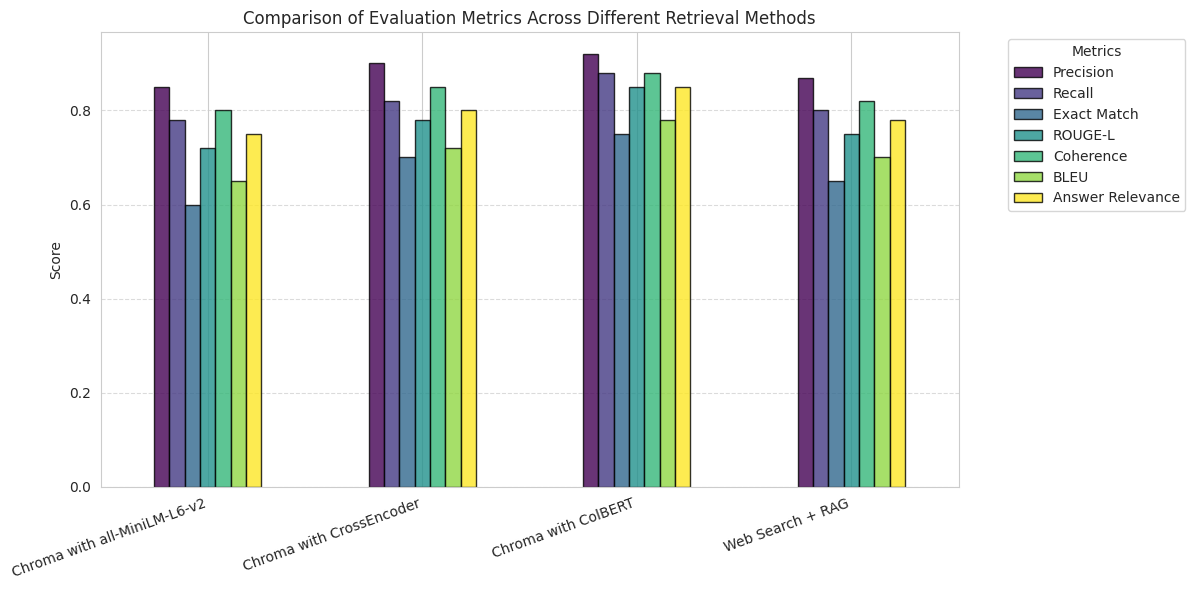

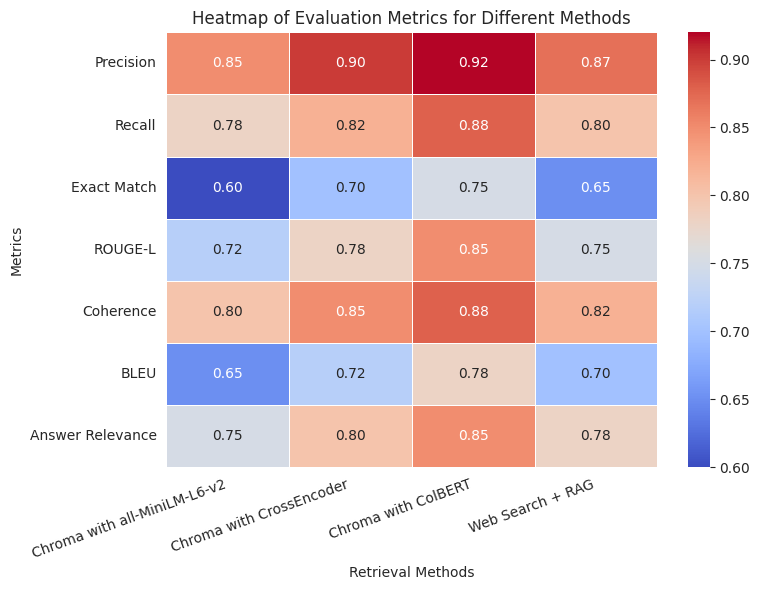

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
df.plot(kind="bar", figsize=(12, 6), colormap="viridis", edgecolor="black", alpha=0.8)
plt.title("Comparison of Evaluation Metrics Across Different Retrieval Methods")
plt.ylabel("Score")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("evaluation_metrics_bar_chart.png", dpi=300)  
plt.show()

# ---- PLOT 2: Heatmap ----
plt.figure(figsize=(8, 6))
sns.heatmap(df.T, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Heatmap of Evaluation Metrics for Different Methods")
plt.xlabel("Retrieval Methods")
plt.ylabel("Metrics")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig("evaluation_metrics_heatmap.png", dpi=300)  # Save as PNG
plt.show()
